In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import xml.etree.ElementTree as ET , time
from keras.applications.vgg16 import preprocess_input as pi
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
# !pip install git+https://github.com/tensorflow/examples.git
# !pip install segmentation_models


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = []

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
#     plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))#,cmap='gray')
    plt.axis('off')
  plt.show()

***All image folders are present in '/kaggle/input/stanford-dogs-dataset/images/Images'   
Annotations in '/kaggle/input/stanford-dogs-dataset/annotations/Annotation'***

In [3]:
img_dir='/kaggle/input/stanford-dogs-dataset/images/Images'
breed_dir='/kaggle/input/stanford-dogs-dataset/annotations/Annotation'

In [4]:
img_list=sorted(os.listdir(img_dir))
annot_dir=sorted(os.listdir(breed_dir))


In [5]:
images=np.zeros((25000,64,64,3))
breeds=[]

In [6]:
N=0
for i in tqdm(range(len(img_list))):
    breed_path=img_dir+'/'+img_list[i]+'/'
    annotation_path=breed_dir+'/'+annot_dir[i]+'/'
    breed_specific_image_list=sorted(os.listdir(breed_path))
    annotation_breed_list=sorted(os.listdir(annotation_path))
    for j in range(len(breed_specific_image_list)):
        img=load_img(breed_path+breed_specific_image_list[j])
        obj=ET.parse(annotation_path+annotation_breed_list[j]).getroot().findall('object')[0].find('bndbox')
        xmin=int(obj.find('xmin').text)
        xmax=int(obj.find('xmax').text)
        ymin=int(obj.find('ymin').text)
        ymax=int(obj.find('ymax').text)
        img2=img.crop((xmin,ymin,xmax,ymax))
        img2=img2.resize((64,64))
        
        images[N]=img_to_array(img2)
        breeds.append(img_list[i].split('-')[1])
        
        N+=1

100%|██████████| 120/120 [05:11<00:00,  2.60s/it]


In [19]:
for i in range(len(breeds)):
    breeds[i]=breeds[i].lower()

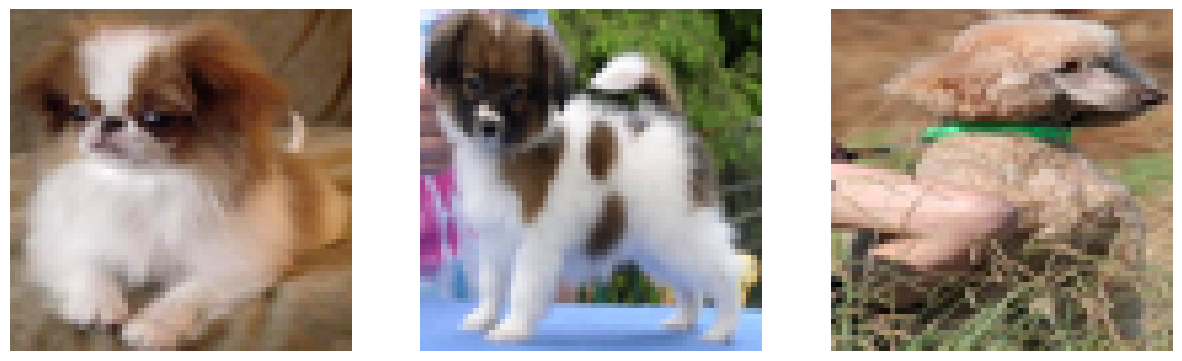

In [20]:
display([images[193],images[1333],images[19833]])

In [21]:
t_x=images
t_y=breeds

In [22]:
images=t_x
breeds=t_y

In [23]:
images=images[:N]
breeds=breeds[:N]
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
breeds=le.fit_transform(breeds)
images = images.astype("float32")/255.

In [24]:
images.shape

(20580, 64, 64, 3)

In [25]:
from keras.preprocessing.image import ImageDataGenerator
X_train = images
Y_train = breeds
shift = 0.2
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=360,
    width_shift_range=shift,
    height_shift_range=shift, shear_range=0.2,
    zoom_range=0.2, channel_shift_range=4.,
    horizontal_flip=True, vertical_flip=True,
    rescale=1. /255,
    fill_mode='nearest')

datagen.fit(images)



# Concatenating the old data with the augmented data
train_x  = np.concatenate((images, X_train), axis=0)
train_y  = np.concatenate((breeds, Y_train), axis=0)
print(train_x.shape)
print(train_y.shape)

(41160, 64, 64, 3)
(41160,)


In [26]:
BATCH_SIZE=32
MAPS = 128
noise_dim = 128
from tensorflow.keras.layers import *
from tensorflow.keras import layers
from tensorflow.keras.initializers import RandomNormal
init = RandomNormal(mean=0.0, stddev=0.02)

def make_generator():
    seed = tf.keras.Input(shape=((noise_dim,)))                # Noise input dim-128,
    label = tf.keras.Input(shape=((1,)))                       # Label input
    x = layers.Embedding(120, 120, input_length=1,name='emb')(label)
    x = layers.Flatten()(x)
    x = layers.concatenate([seed,x])
    x = layers.Dense(4*4*MAPS*8, use_bias=False)(x)
    x = layers.Reshape((4, 4, MAPS*8))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2DTranspose(MAPS*4, (5, 5), strides=(2, 2), padding='same', kernel_initializer=init, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2DTranspose(MAPS*2, (5, 5), strides=(2, 2), padding='same', kernel_initializer=init, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2DTranspose(MAPS, (5, 5), strides=(2, 2), padding='same', kernel_initializer=init, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', kernel_initializer=init, use_bias=False, activation='tanh')(x)

    model = tf.keras.Model(inputs=[seed,label], outputs=x)    
    return model

generator = make_generator()
generator.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 emb (Embedding)                (None, 1, 120)       14400       ['input_6[0][0]']                
                                                                                                  
 input_5 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 flatten_2 (Flatten)            (None, 120)          0           ['emb[0][0]']                    
                                                                                            

/opt/conda/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [27]:
GNOISE = 0.25

def make_discriminator():
    image = tf.keras.Input(shape=((64,64,3)))
    label = tf.keras.Input(shape=((1,)))
    x = layers.Embedding(120, 64*64, input_length=1)(label)
    x = layers.Reshape((64,64,1))(x)
    x = layers.concatenate([image,x])
    
    x = layers.Conv2D(MAPS, (5, 5), strides=(2, 2), padding='same', kernel_initializer=init, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    #x = layers.GaussianNoise(GNOISE)(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(MAPS*2, (5, 5), strides=(2, 2), padding='same', kernel_initializer=init, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    #x = layers.GaussianNoise(GNOISE)(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(MAPS*4, (5, 5), strides=(2, 2), padding='same', kernel_initializer=init, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    #x = layers.GaussianNoise(GNOISE)(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(MAPS*8, (5, 5), strides=(2, 2), padding='same', kernel_initializer=init, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    #x = layers.GaussianNoise(GNOISE)(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(121, activation='sigmoid')(x)
    x2 = layers.Dense(1, activation='linear')(x)
    
    model = tf.keras.Model(inputs=[image,label], outputs=[x,x2])
    return model

discriminator = make_discriminator()
discriminator.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 4096)      491520      ['input_8[0][0]']                
                                                                                                  
 input_7 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 reshape_3 (Reshape)            (None, 64, 64, 1)    0           ['embedding_1[0][0]']            
                                                                                            

In [28]:

# OPTIMIZER - ADAM
learning_rate = 0.0002
print(learning_rate)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

0.0002


Shuffling the train data and creating batches

In [29]:
idx = np.arange(N*2)
np.random.shuffle(idx)
dataset = (tf.data.Dataset.from_tensor_slices((train_x[idx,:,:,:],train_y[idx])).batch(BATCH_SIZE,drop_remainder=True))
    

100%|██████████| 1286/1286 [05:47<00:00,  3.70it/s]


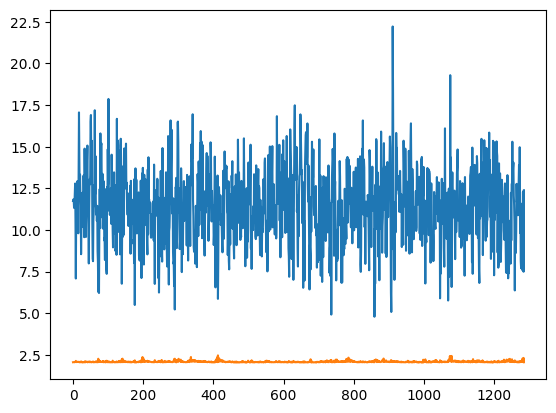

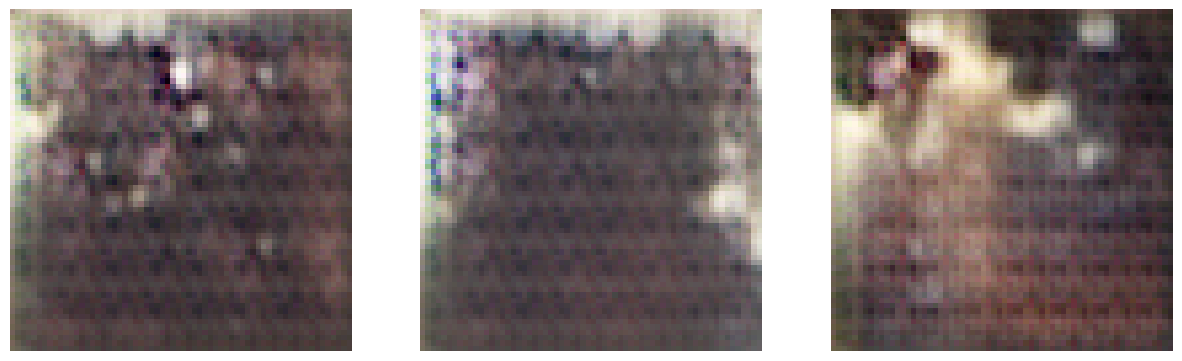

Average gen loss: 11.402034
Average disc loss: 2.0838928


100%|██████████| 1286/1286 [05:46<00:00,  3.71it/s]


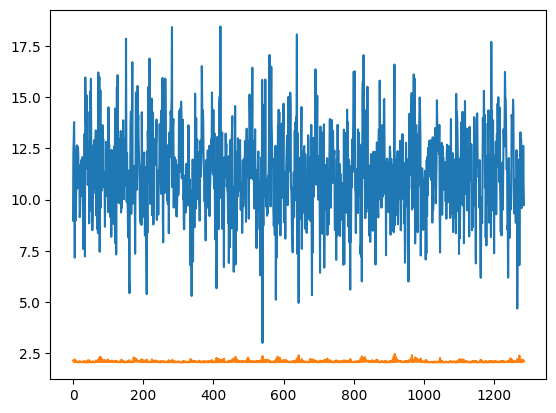

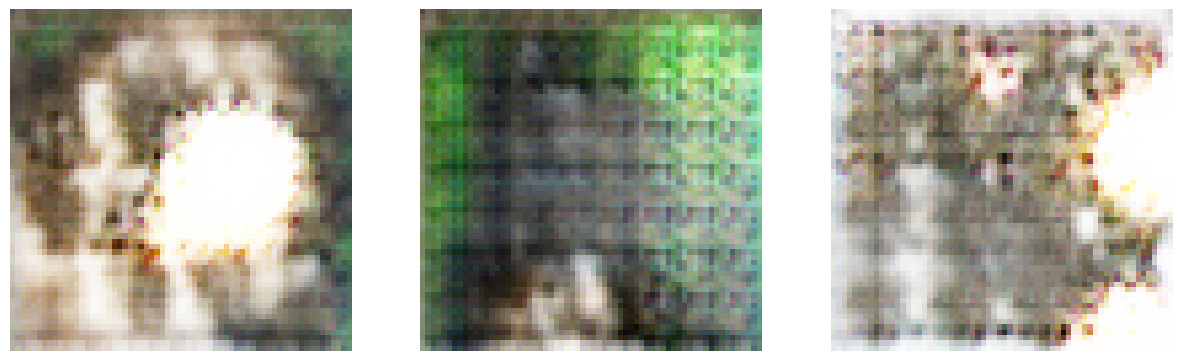

Average gen loss: 11.225171
Average disc loss: 2.0828943


100%|██████████| 1286/1286 [05:46<00:00,  3.71it/s]


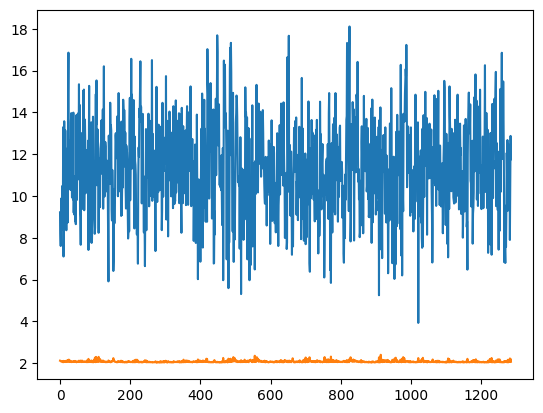

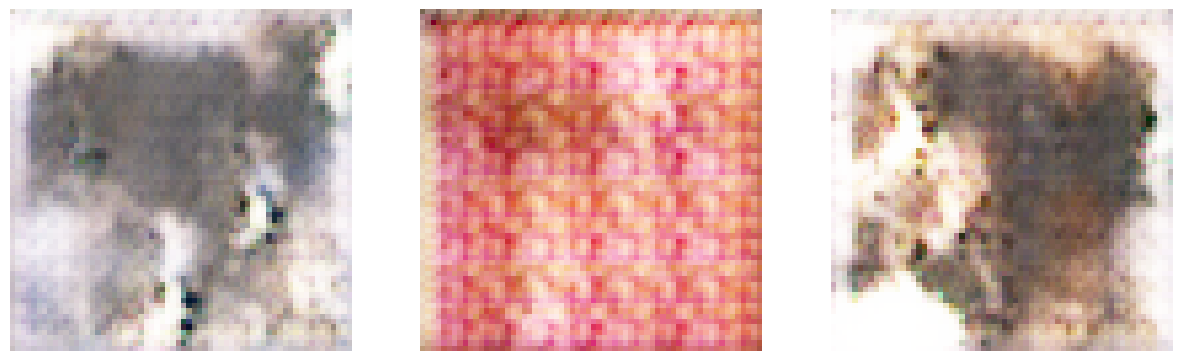

Average gen loss: 11.2899885
Average disc loss: 2.0798445


100%|██████████| 1286/1286 [05:51<00:00,  3.66it/s]


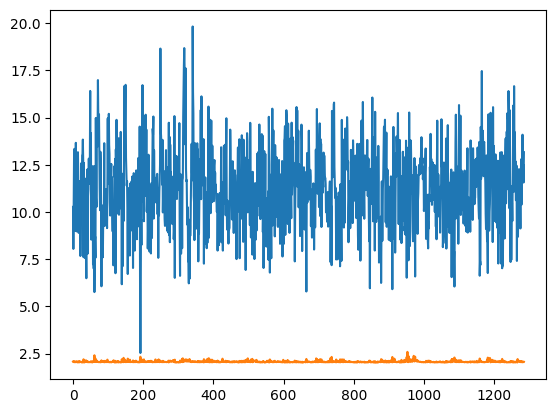

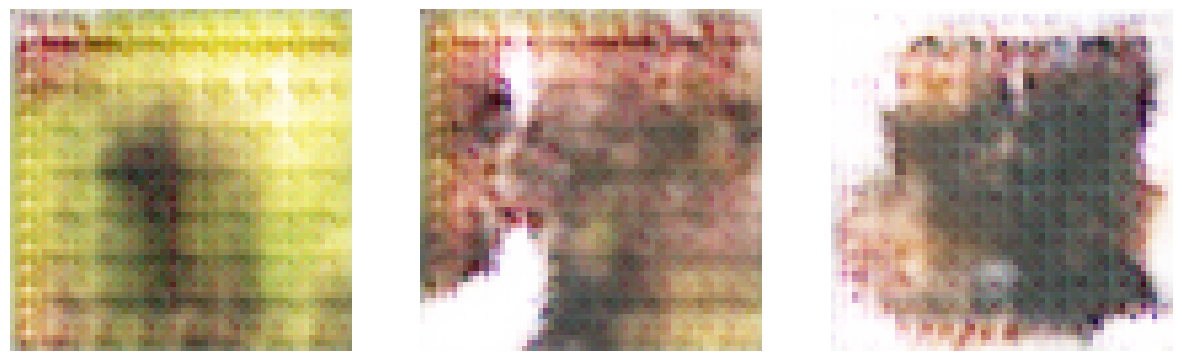

Average gen loss: 11.204181
Average disc loss: 2.0808814


100%|██████████| 1286/1286 [05:47<00:00,  3.70it/s]


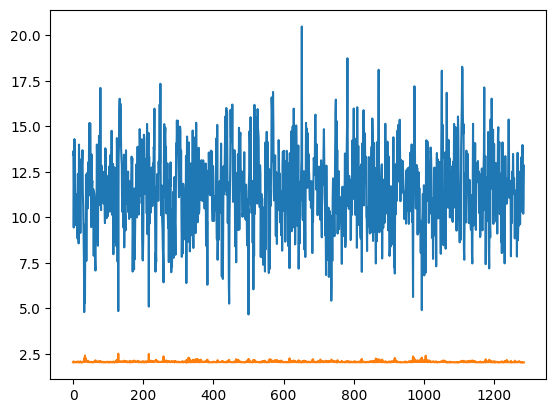

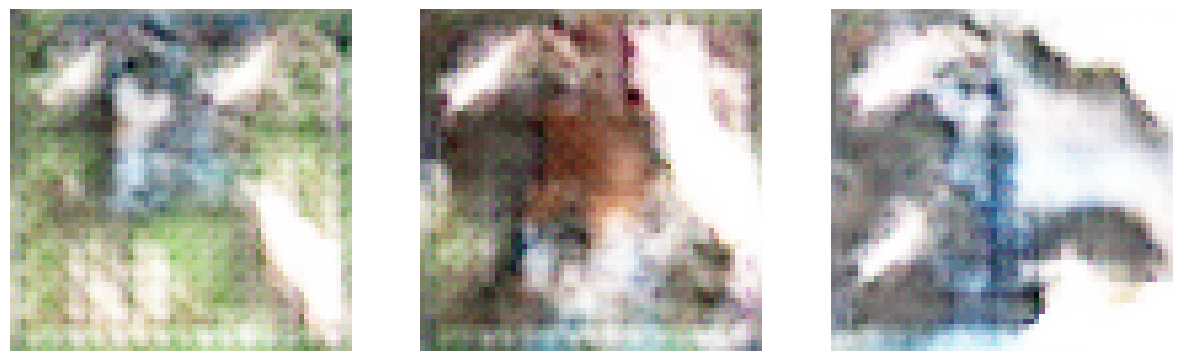

Average gen loss: 11.412616
Average disc loss: 2.0709906


100%|██████████| 1286/1286 [05:47<00:00,  3.70it/s]


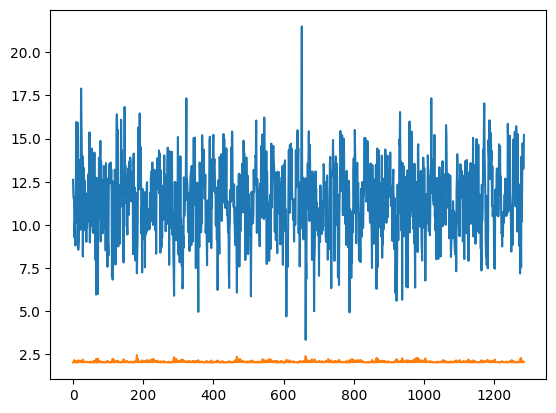

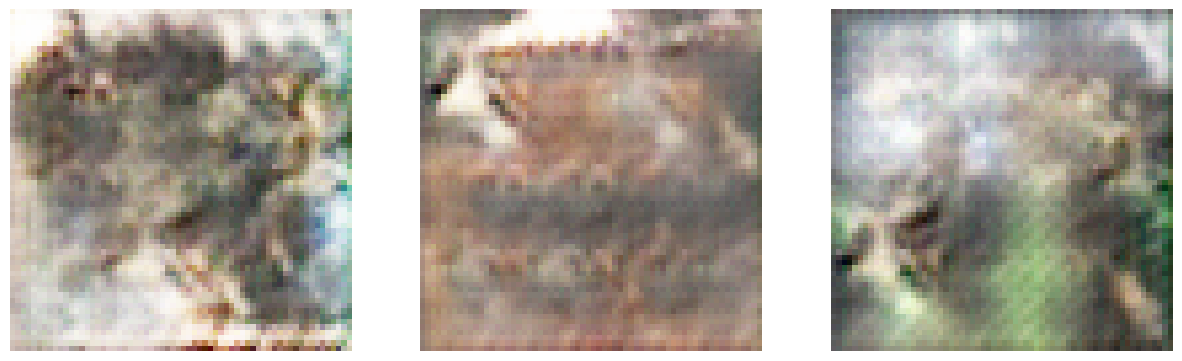

Average gen loss: 11.423796
Average disc loss: 2.0717192


100%|██████████| 1286/1286 [05:47<00:00,  3.70it/s]


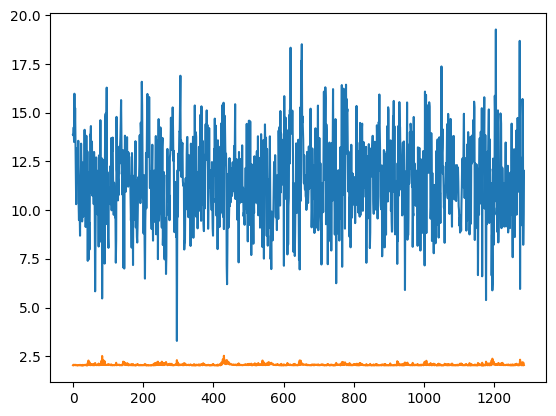

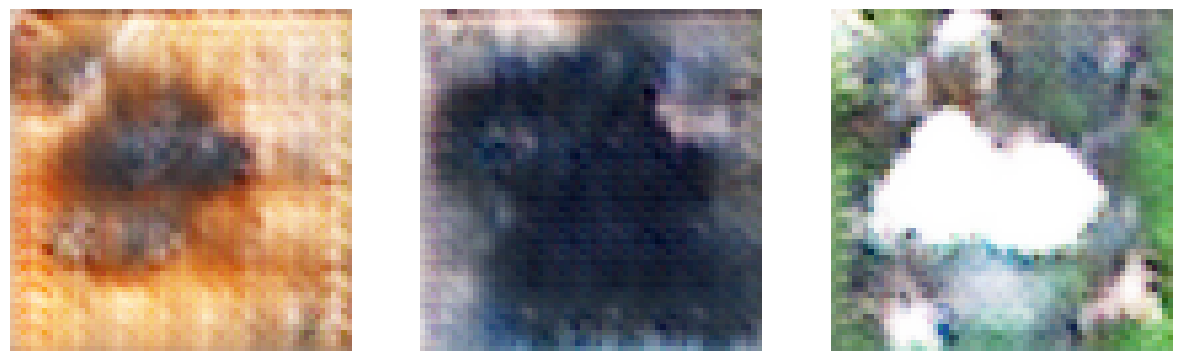

Average gen loss: 11.5395775
Average disc loss: 2.0692358


100%|██████████| 1286/1286 [05:48<00:00,  3.69it/s]


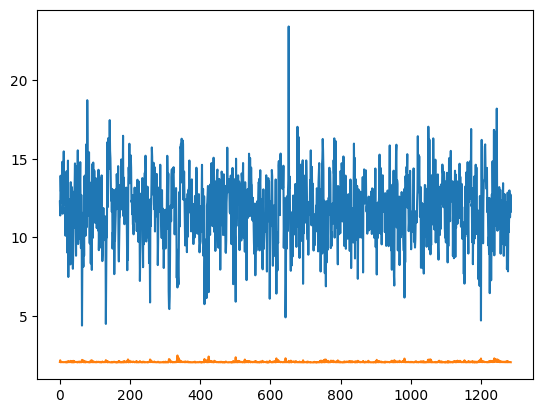

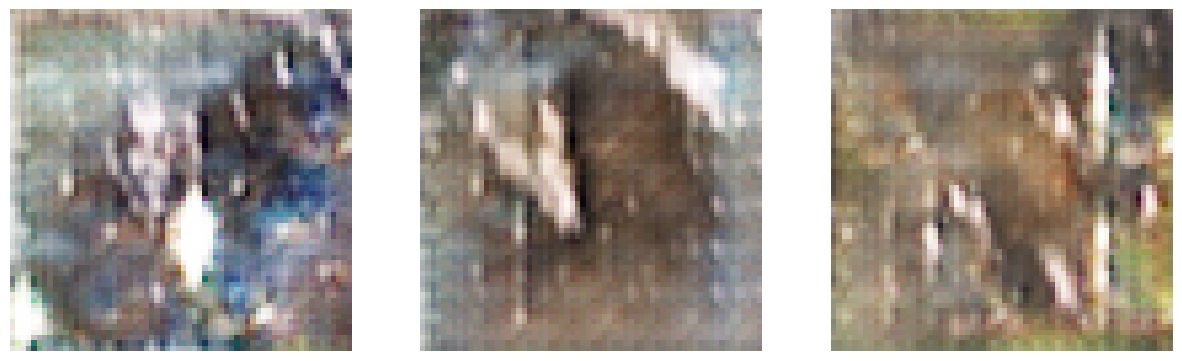

Average gen loss: 11.77067
Average disc loss: 2.061819


100%|██████████| 1286/1286 [05:48<00:00,  3.69it/s]


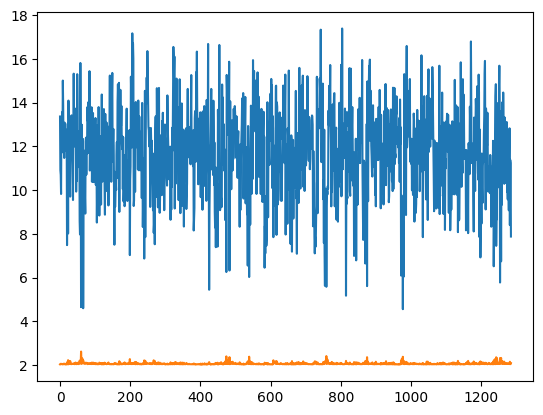

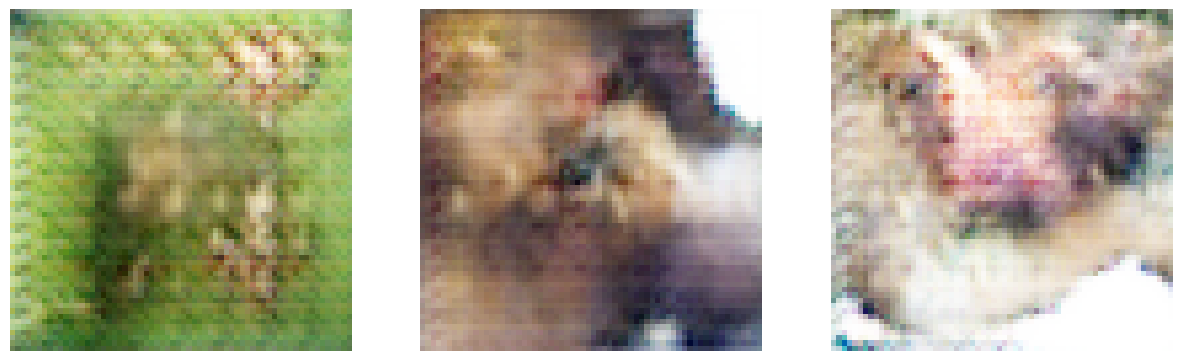

Average gen loss: 11.704355
Average disc loss: 2.0628183


100%|██████████| 1286/1286 [05:48<00:00,  3.69it/s]


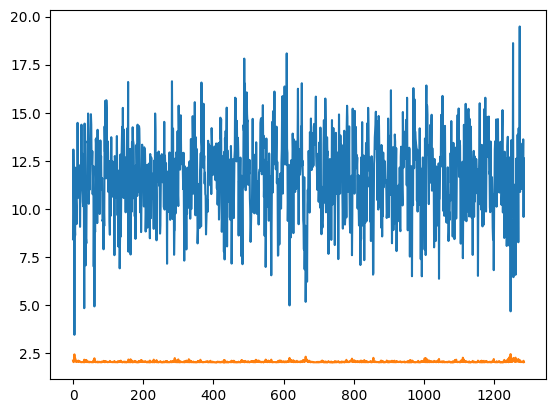

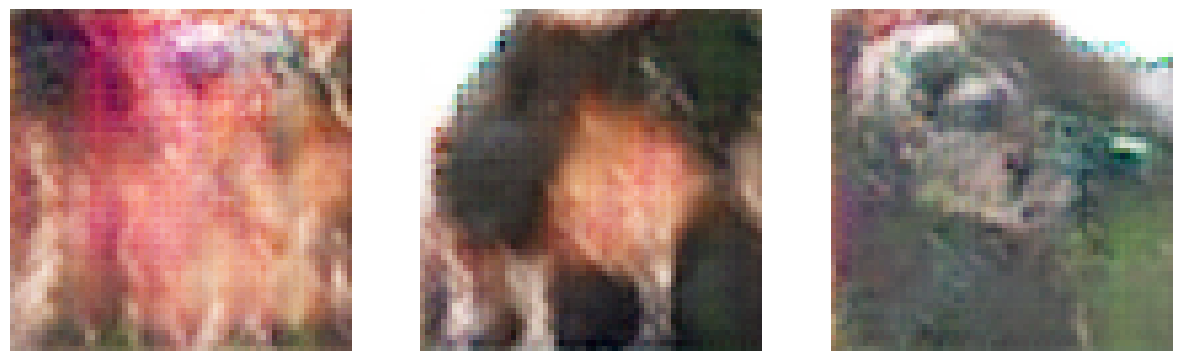

Average gen loss: 11.666005
Average disc loss: 2.0614998


In [40]:
EPOCHS=10
BATCH_SIZE=32
for epoch in range(EPOCHS):
    gl=[]
    dl=[]
    
    for i,image_set in tqdm(enumerate(dataset),total=len(dataset)):
    #     image_set=dataset.as_numpy_iterator().next()

        bce = tf.keras.losses.BinaryCrossentropy(from_logits=True,label_smoothing=0.4)   ##For discriminator loss
        bce2 = tf.keras.losses.BinaryCrossentropy(from_logits=False,label_smoothing=0.4) ##For discriminator loss

        #Give noise(Random image space) and labs acts as the labels
        noise = tf.random.normal((32,128)) # update noise_dim here
        labs = tf.cast(120*tf.random.uniform((32,)),tf.int32) #Creates a tensor using the uniform array, where the values are multiplied by 120 and turned int

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  

            #Generator Loss
            generated_images = generator([noise,labs], training=True)
            real_cat, real_output = discriminator([image_set[0],image_set[1]], training=True)
            fake_cat, fake_output = discriminator([generated_images,labs], training=True)
            gen_loss = (tf.reduce_mean( (real_output - tf.reduce_mean(fake_output,0) + tf.ones_like(real_output))**2,0 )
            + tf.reduce_mean( (fake_output - tf.reduce_mean(real_output,0) - tf.ones_like(real_output))**2,0 ) )/2.

            #Discriminator Loss
            disc_loss = bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)           
            real_cat2 = tf.one_hot(tf.cast(image_set[1],tf.int32),121,dtype=tf.int32)
            fake_cat2 = tf.one_hot(120*tf.ones((32,),tf.int32),121,dtype=tf.int32)
            disc_loss += bce2(real_cat2,real_cat) + bce2(fake_cat2,fake_cat)

            # BACK PROPAGATE ERROR
            gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
            gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

            gl.append(gen_loss)
            dl.append(disc_loss)
            
    ax=plt.subplot()
    ax.plot(gl)
    ax.plot(dl)
    plt.show()
    
    display([generated_images[0],generated_images[1],generated_images[2]])
    print('Average gen loss:',np.array(gl).mean())
    print('Average disc loss:',np.array(dl).mean())

In [73]:
discriminator.save_weights('/kaggle/working/Weights/Discriminator/')

In [76]:
zip_name = f"/kaggle/working/download.zip"

In [ ]:
command = f"zip download.zip {path} -r"

9


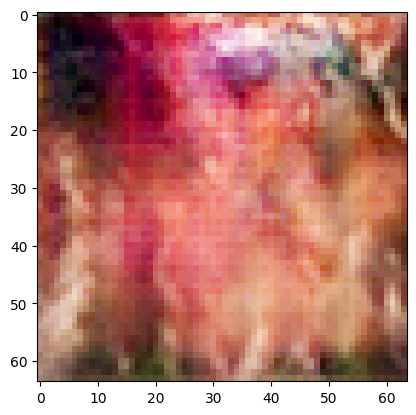

In [48]:
print(epoch)
plt.imshow(generated_images[0])

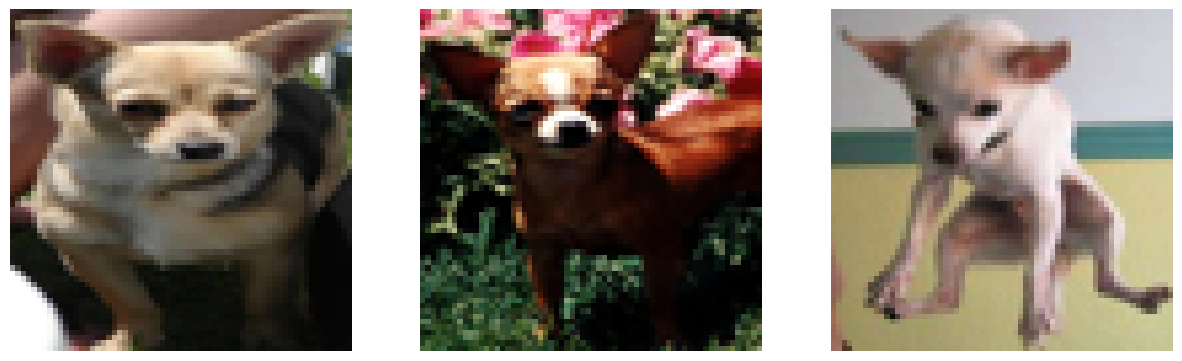

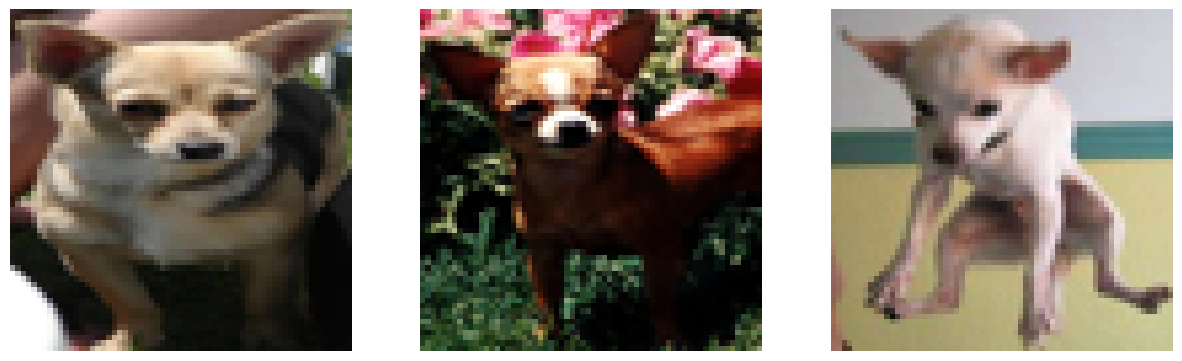

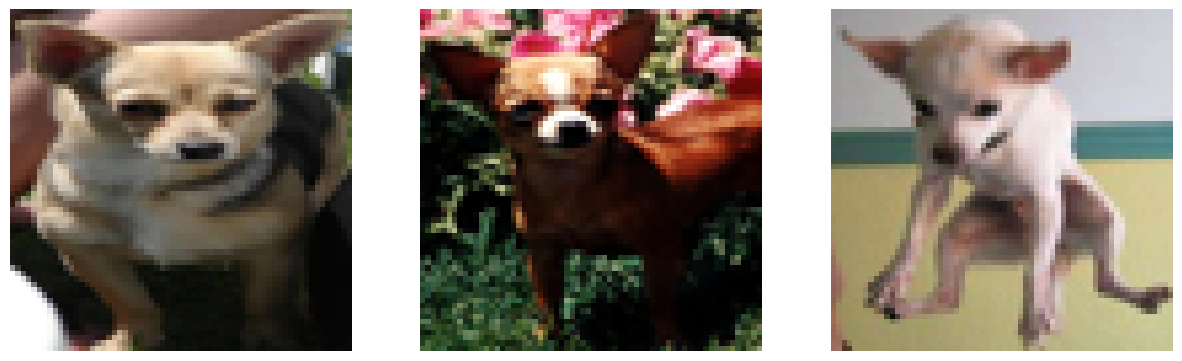

In [33]:
for i in range(3):
    display([images[0],images[1],images[2]])

In [39]:
print('Average gen loss:',np.array(gl).mean())
print('Average disc loss:',np.array(dl).mean())

Average gen loss: 11.573122
Average disc loss: 2.0872655
